In [33]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model

### I can start by importing the root mask predicted in task 5

In [34]:
#image = cv2.imread("task5_test_image_prediction_michal_232079_v3.png", cv2.IMREAD_GRAYSCALE)
image = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)


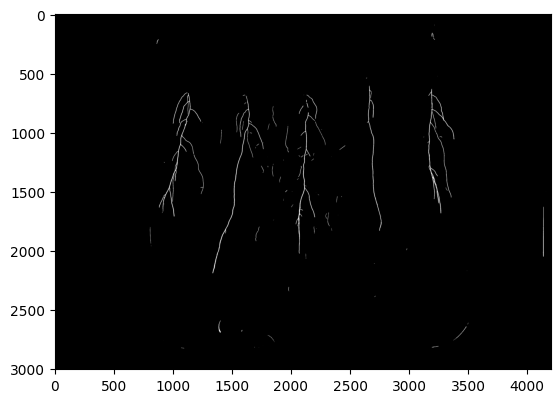

In [35]:
plt.imshow(image, cmap='gray')

### Morphological operations

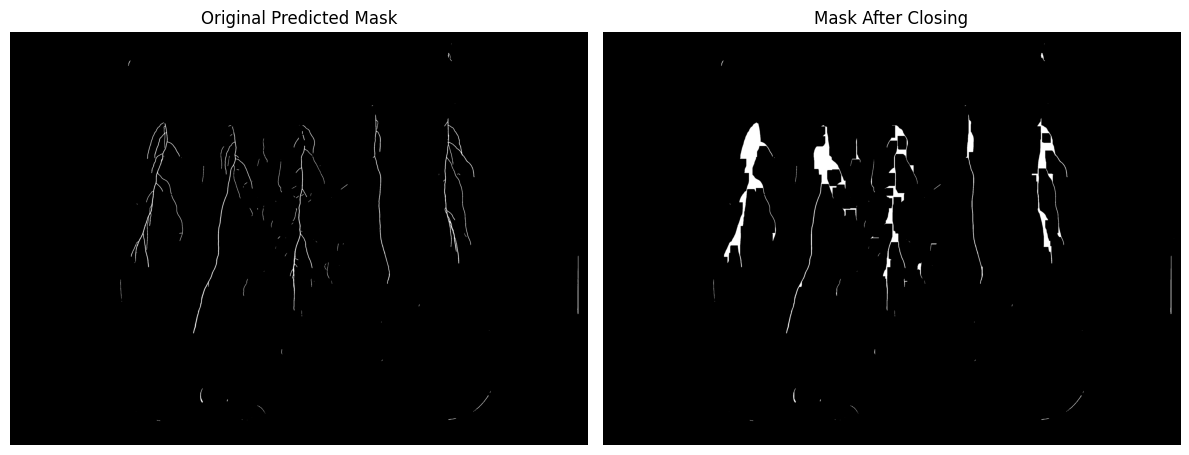

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define Morphological Operations
def apply_closing_only(mask,kernel):
    """
    Apply only closing to fill gaps without removing thin structures.
    """
    kernel = np.ones(kernel, np.uint8)  # Structuring element
    # Perform closing (dilation followed by erosion) to fill gaps
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask

# Step 2: Apply Morphological Closing
closed_mask = apply_closing_only(image, (51,51))

# Step 3: Visualize the Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Predicted Mask")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask After Closing")
plt.imshow(closed_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


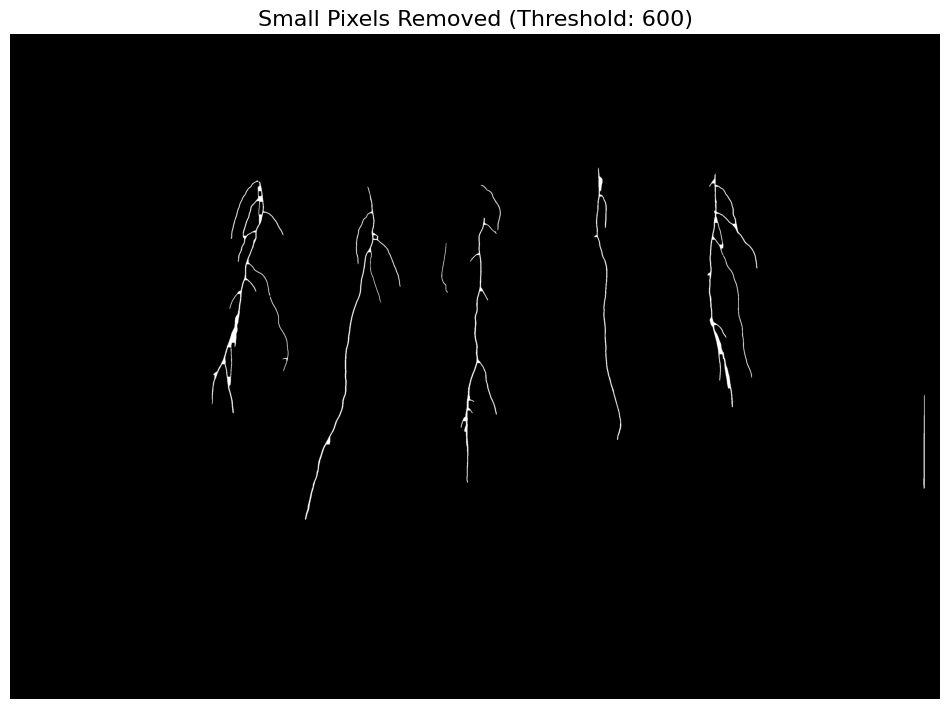

In [37]:
from skimage import morphology
#Remove small objects
size_threshold = 600 # Minimum size of components to keep

filtered_mask = morphology.remove_small_objects(image > 0, min_size=size_threshold).astype('uint8') * 255
filtered_mask = apply_closing_only(filtered_mask, (12,12))

#Display the result
plt.figure(figsize=(12, 12))
plt.imshow(filtered_mask, cmap='gray')
plt.title(f"Small Pixels Removed (Threshold: {size_threshold})", fontsize=16)
plt.axis('off')
plt.show()

### I will use the bounding boxes approach, similarly to task 3:

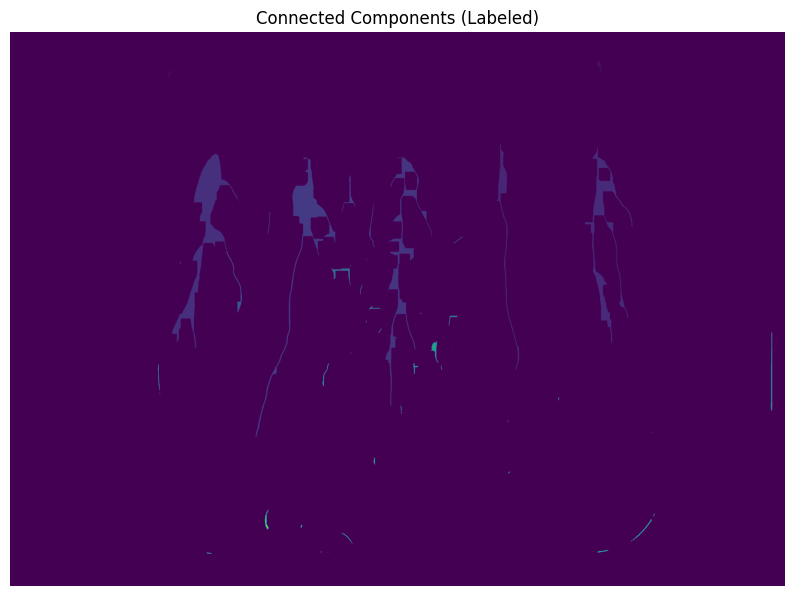

In [38]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_mask)

plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='viridis')
plt.title("Connected Components (Labeled)")
plt.axis('off')
plt.show()

### Segmenting the roots based of the bounding boxes:

In [39]:
def extract_bounding_boxes_from_stats(stats, min_area=200):
    """
    Extract bounding boxes from connected component stats.
    
    Parameters:
        stats (np.ndarray): Statistics from connected components (x, y, width, height, area).
        min_area (int): Minimum area threshold for valid bounding boxes.
    
    Returns:
        list: List of bounding boxes [(x_min, y_min, x_max, y_max), ...].
    """
    bounding_boxes = []
    for stat in stats[1:]:  # Skip the background (index 0)
        x, y, w, h, area = stat
        if area >= min_area:
            bounding_boxes.append((x, y, x + w, y + h))
    return bounding_boxes

# Extract bounding boxes from stats
bounding_boxes = extract_bounding_boxes_from_stats(stats)

# Print the number of bounding boxes
print(f"Number of valid bounding boxes: {len(bounding_boxes)}")


Number of valid bounding boxes: 20


In [40]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU
    return inter_area / union_area if union_area > 0 else 0


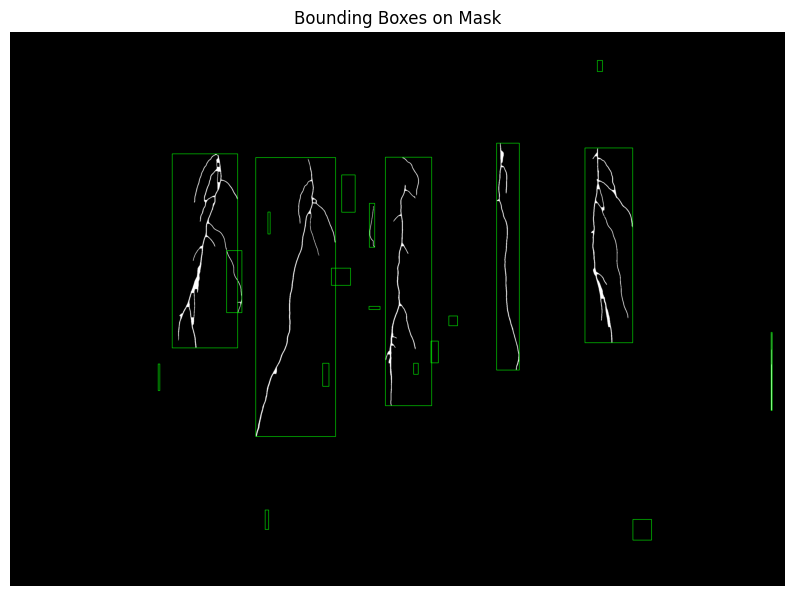

In [41]:
def draw_bounding_boxes_on_mask(mask, bboxes):
    """
    Draw bounding boxes on the binary mask.
    
    Parameters:
        mask (np.ndarray): Original or cleaned binary mask.
        bboxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].
    
    Returns:
        np.ndarray: Mask with bounding boxes drawn.
    """
    # Convert mask to BGR for color visualization
    mask_with_bboxes = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Draw bounding boxes in green
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(mask_with_bboxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    return mask_with_bboxes

# Visualize bounding boxes on the cleaned mask
mask_with_bboxes = draw_bounding_boxes_on_mask(filtered_mask, bounding_boxes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(mask_with_bboxes, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes on Mask")
plt.axis('off')
plt.show()


### Code to handle overlapping boxes, and only leave the largest one:

In [42]:
def non_maximum_suppression(bboxes, iou_threshold=0.01, min_y_threshold=700, exclude_top_y=150):
    """
    Apply Non-Maximum Suppression (NMS) to remove overlapping bounding boxes,
    exclude boxes starting below a specified y-axis threshold, and exclude
    boxes overlapping the top 150 pixels of the y-axis.
    
    Parameters:
        bboxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].
        iou_threshold (float): Threshold for IoU to consider boxes as overlapping.
        min_y_threshold (int): Minimum y_min value for a bounding box to be kept.
        exclude_top_y (int): Exclude boxes with y_min <= this value.
    
    Returns:
        list: Filtered list of bounding boxes after NMS.
    """
    if len(bboxes) == 0:
        return []
    
    # Filter out boxes where y_min is below the min_y_threshold or overlaps the top exclude_top_y
    bboxes = [box for box in bboxes if exclude_top_y < box[1] < min_y_threshold]
    
    # Convert bounding boxes to numpy array
    bboxes = np.array(bboxes)
    if len(bboxes) == 0:
        return []
    
    # Compute areas of each bounding box
    areas = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    
    # Sort bounding boxes by area (descending order)
    sorted_indices = np.argsort(areas)[::-1]
    bboxes = bboxes[sorted_indices]
    
    # List to hold filtered boxes
    filtered_bboxes = []
    
    while len(bboxes) > 0:
        # Take the largest box and add it to the result
        current_box = bboxes[0]
        filtered_bboxes.append(current_box)
        bboxes = bboxes[1:]  # Remove the current box
        
        # Compute IoU with remaining boxes
        to_keep = []
        for box in bboxes:
            # Calculate intersection
            x_min = max(current_box[0], box[0])
            y_min = max(current_box[1], box[1])
            x_max = min(current_box[2], box[2])
            y_max = min(current_box[3], box[3])
            inter_area = max(0, x_max - x_min) * max(0, y_max - y_min)
            
            # Calculate union
            union_area = (
                (current_box[2] - current_box[0]) * (current_box[3] - current_box[1]) +
                (box[2] - box[0]) * (box[3] - box[1]) -
                inter_area
            )
            
            # Calculate IoU
            iou = inter_area / union_area
            
            # Keep the box if IoU is below the threshold
            if iou <= iou_threshold:
                to_keep.append(box)
        
        bboxes = np.array(to_keep)  # Update remaining boxes
    
    return filtered_bboxes


### In application:

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define Morphological Operations
def apply_closing_only(mask):
    """
    Apply only closing to fill gaps without removing thin structures.
    """
    kernel = np.ones((15, 15), np.uint8)  # Structuring element
    # Perform closing (dilation followed by erosion) to fill gaps
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask



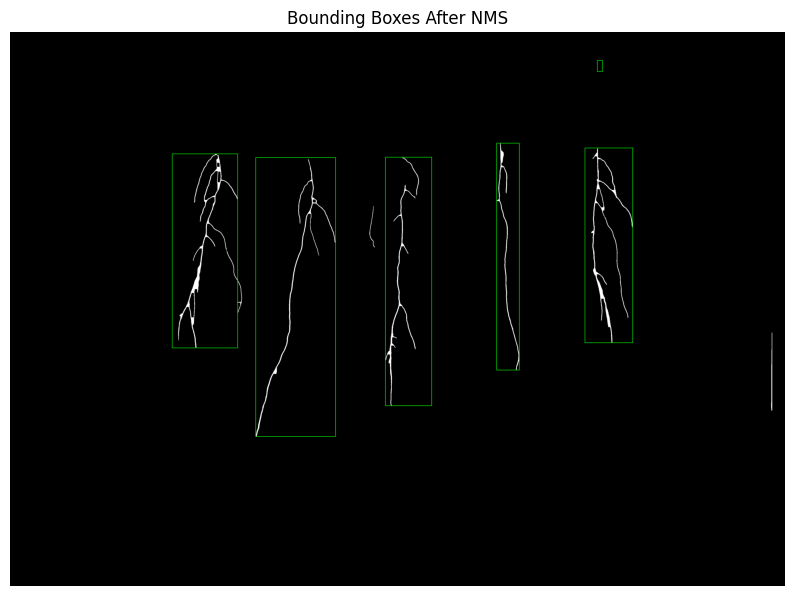

In [44]:
# Extract bounding boxes from stats
bounding_boxes = extract_bounding_boxes_from_stats(stats)

# Apply Non-Maximum Suppression to remove overlapping boxes
filtered_bounding_boxes = non_maximum_suppression(bounding_boxes, iou_threshold=0.0001)

# Visualize bounding boxes after NMS
mask_with_bboxes_nms = draw_bounding_boxes_on_mask(filtered_mask, filtered_bounding_boxes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(mask_with_bboxes_nms, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes After NMS")
plt.axis('off')
plt.show()


In [45]:
from scipy.ndimage import label

def create_single_component_labeled_mask(original_mask, bounding_boxes):
    """
    Create a labeled mask where each bounding box corresponds to exactly one connected component.

    Parameters:
        original_mask (np.ndarray): Original binary mask.
        bounding_boxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].

    Returns:
        np.ndarray: Labeled mask with one component per bounding box, each labeled with a unique integer.
    """
    # Initialize a blank mask with the same shape as the original mask
    labeled_mask = np.zeros_like(original_mask, dtype=np.uint16)

    for label_id, bbox in enumerate(bounding_boxes, start=1):  # Start labels from 1
        x_min, y_min, x_max, y_max = bbox

        # Crop the region of the root from the original mask
        root_region = original_mask[y_min:y_max, x_min:x_max]

        # Label connected components within this region
        labeled_components, num_components = label(root_region > 0)

        if num_components > 0:
            # Find the largest connected component
            component_sizes = [(labeled_components == i).sum() for i in range(1, num_components + 1)]
            largest_component_idx = component_sizes.index(max(component_sizes)) + 1  # 1-based index

            # Extract the largest component and assign its label
            largest_component = (labeled_components == largest_component_idx)
            labeled_mask[y_min:y_max, x_min:x_max][largest_component] = label_id

    return labeled_mask


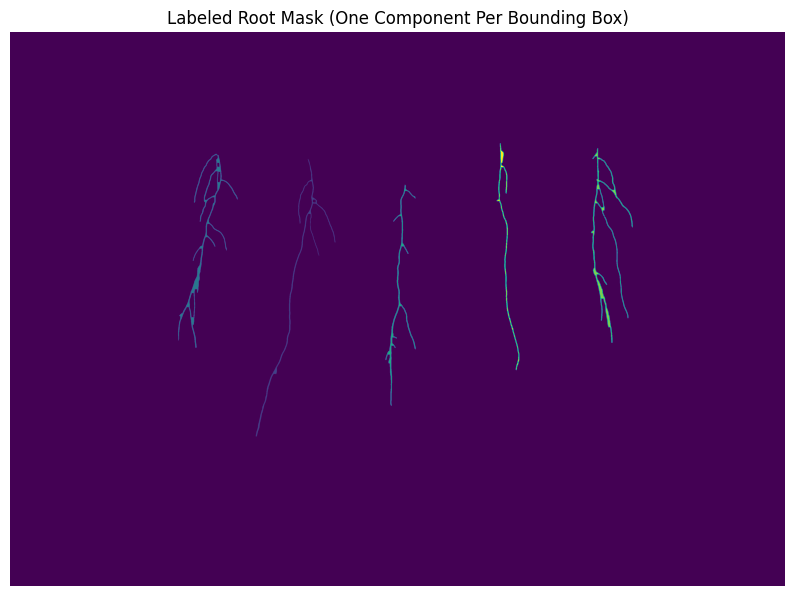

Number of components: 5


In [46]:
# Create the labeled mask with one component per bounding box
labeled_root_mask = create_single_component_labeled_mask(filtered_mask, filtered_bounding_boxes)

# Visualize the labeled mask
plt.figure(figsize=(10, 10))
plt.imshow(labeled_root_mask, cmap='viridis')  # Use a colormap for better visualization
plt.title("Labeled Root Mask (One Component Per Bounding Box)")
plt.axis('off')
plt.show()

# Count the number of components
unique_labels = np.unique(labeled_root_mask)
print(f"Number of components: {len(unique_labels) - 1}")  # Exclude background (label 0)


### As you may observe, some lateral roots are being excluded however the core root remains untouched which is the main focus of this task.

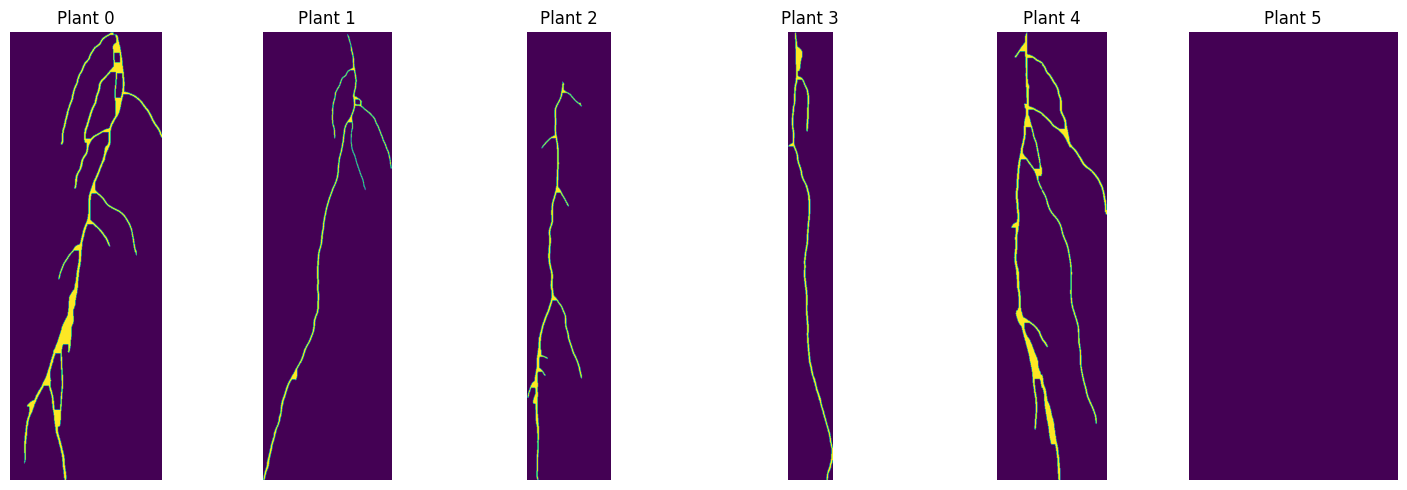

In [47]:
def visualize_cropped_roots_from_left_to_right(labeled_mask, bounding_boxes):
    """
    Visualize segmented and cropped roots sorted from left to right based on their position.

    Parameters:
        labeled_mask (np.ndarray): Labeled mask with each root assigned a unique integer label.
        bounding_boxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Sort bounding boxes based on their x_min values
    sorted_bboxes = sorted(enumerate(bounding_boxes), key=lambda x: x[1][0])  # Sort by x_min

    # Create subplots
    num_roots = len(sorted_bboxes)
    fig, axes = plt.subplots(1, num_roots, figsize=(15, 5))

    for i, (idx, bbox) in enumerate(sorted_bboxes):
        x_min, y_min, x_max, y_max = bbox

        # Crop the labeled mask to the bounding box
        cropped_root = labeled_mask[y_min:y_max, x_min:x_max]

        # Display the cropped root
        ax = axes[i]
        ax.imshow(cropped_root, cmap='viridis')
        ax.set_title(f"Plant {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize the cropped roots
visualize_cropped_roots_from_left_to_right(labeled_root_mask, filtered_bounding_boxes)


### TASK 7

In [48]:
from skan import Skeleton, summarize
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [49]:
def calculate_and_visualize_primary_root_lengths(labeled_mask, original_mask):
    """
    Calculate primary root lengths for each root in the labeled mask and visualize
    the start and end points on the skeleton overlaid on the original mask.

    Parameters:
        labeled_mask (np.ndarray): Labeled mask with each root assigned a unique integer label.
        original_mask (np.ndarray): Original binary mask of the roots.

    Returns:
        dict: Dictionary of root IDs and their calculated lengths.
    """
    from skimage.morphology import skeletonize
    from skan.csr import skeleton_to_csgraph
    import networkx as nx
    import matplotlib.pyplot as plt

    # Skeletonize the entire mask
    skeleton = skeletonize(labeled_mask > 0)

    # Sort root IDs from left to right based on their bounding boxes
    root_ids = np.unique(labeled_mask)
    root_ids = root_ids[root_ids > 0]  # Exclude background
    bounding_boxes = {
        rid: (np.min(np.where(labeled_mask == rid)[1]),  # x_min
              np.max(np.where(labeled_mask == rid)[1]))  # x_max
        for rid in root_ids
    }
    sorted_root_ids = sorted(root_ids, key=lambda rid: bounding_boxes[rid][0])

    primary_root_lengths = {}

    # Plotting setup
    plt.figure(figsize=(10, 10))
    plt.imshow(original_mask, cmap='gray')
    plt.title("Skeleton with Start (Green) and End (Red) Points")

    for idx, root_id in enumerate(sorted_root_ids, start=1):
        # Isolate the skeleton for the current root
        root_skeleton = (labeled_mask == root_id) & skeleton

        # Convert skeleton to graph and coordinates
        graph, coordinates = skeleton_to_csgraph(root_skeleton)

        # Convert sparse graph to NetworkX graph
        G = nx.Graph()
        for i, j in zip(*graph.nonzero()):
            G.add_edge(i, j, weight=graph[i, j])

        # Identify topmost and bottommost nodes
        try:
            topmost_node = min(G.nodes, key=lambda n: coordinates[0][n])  # Smallest y (row)
            bottommost_node = max(G.nodes, key=lambda n: coordinates[0][n])  # Largest y (row)

            # Compute the shortest path length using Dijkstra
            dist = nx.dijkstra_path_length(G, source=topmost_node, target=bottommost_node, weight='weight')
            primary_root_lengths[idx] = dist

            # Get coordinates of start and end points
            start_coords = (coordinates[0][topmost_node], coordinates[1][topmost_node])  # (row, col)
            end_coords = (coordinates[0][bottommost_node], coordinates[1][bottommost_node])  # (row, col)

            # Overlay points on the visualization
            plt.scatter(start_coords[1], start_coords[0], c='green', s=100, label=f"Start" if idx == 1 else "")
            plt.scatter(end_coords[1], end_coords[0], c='red', s=100, label=f"End" if idx == 1 else "")

            print(f"Root {idx}: Start {start_coords}, End {end_coords}, Length: {dist:.2f}")
        except Exception as e:
            print(f"Root {idx}: Error calculating path - {e}")

    plt.legend()
    plt.axis('off')
    plt.show()

    return primary_root_lengths


Root 1: Start (669, 1114), End (1713, 1008), Length: 1161.03
Root 2: Start (692, 1615), End (2194, 1334), Length: 1656.08
Root 3: Start (832, 2141), End (2026, 2067), Length: 1263.45
Root 4: Start (610, 2658), End (1834, 2744), Length: 1301.04
Root 5: Start (634, 3187), End (1685, 3263), Length: 1126.93


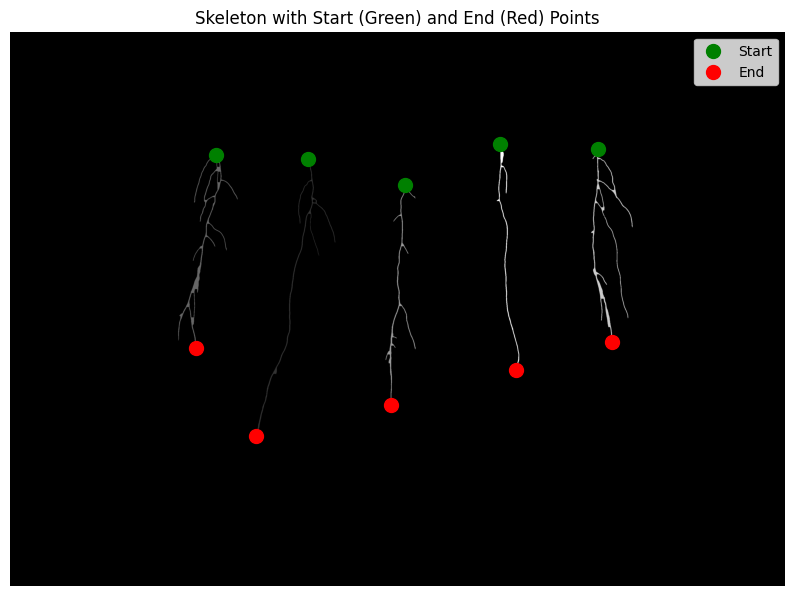

Root 1: Primary Root Length = 1161.03 pixels
Root 2: Primary Root Length = 1656.08 pixels
Root 3: Primary Root Length = 1263.45 pixels
Root 4: Primary Root Length = 1301.04 pixels
Root 5: Primary Root Length = 1126.93 pixels


In [50]:
# Example usage
primary_root_lengths = calculate_and_visualize_primary_root_lengths(labeled_root_mask, labeled_root_mask)

# Print lengths
for root_id, length in primary_root_lengths.items():
    print(f"Root {root_id}: Primary Root Length = {length:.2f} pixels")


---

# Debugging

In [51]:
# def debug_root_mask_and_skeleton_v2(labeled_mask):
#     """
#     Debugging function to analyze the labeled mask, skeleton, and graph-coordinates mapping.
#     Handles cases where `coordinates` is a tuple.
    
#     Parameters:
#         labeled_mask (np.ndarray): Labeled mask with each root assigned a unique integer label.
#     """
#     from skimage.morphology import skeletonize
#     from skan.csr import skeleton_to_csgraph
#     import networkx as nx

#     print("### Debugging Labeled Root Mask ###")
#     print(f"Labeled Mask Shape: {labeled_mask.shape}")
#     print(f"Unique Labels in Mask: {np.unique(labeled_mask)} (excluding 0 for background)")

#     print("\n### Skeletonization ###")
#     binary_mask = labeled_mask > 0
#     skeleton = skeletonize(binary_mask)
#     print(f"Skeleton Shape: {skeleton.shape}")
#     print(f"Skeleton Unique Values: {np.unique(skeleton)}")

#     root_ids = np.unique(labeled_mask)
#     root_ids = root_ids[root_ids > 0]
#     print(f"Number of Roots (Unique Labels): {len(root_ids)}")

#     for root_id in root_ids:
#         print(f"\n### Root {root_id} ###")
#         root_skeleton = (labeled_mask == root_id) & skeleton

#         # Attempt to extract graph and coordinates
#         try:
#             graph, coordinates = skeleton_to_csgraph(root_skeleton)
#         except ValueError as e:
#             print(f"Error in skeleton_to_csgraph for Root {root_id}: {e}")
#             continue

#         # Check the structure of `coordinates`
#         if isinstance(coordinates, tuple):
#             print(f"Coordinates is a tuple with length: {len(coordinates)}")
#             for i, coord_component in enumerate(coordinates):
#                 print(f"Component {i}: Shape = {np.shape(coord_component)}, Type = {type(coord_component)}")
#         else:
#             print(f"Coordinates Shape: {coordinates.shape}, Type: {type(coordinates)}")

#         # Graph analysis
#         G = nx.Graph()
#         for i, j in zip(*graph.nonzero()):
#             G.add_edge(i, j, weight=graph[i, j])

#         print(f"NetworkX Graph Nodes: {list(G.nodes)[:10]} (first 10)")
#         print(f"NetworkX Graph Edges: {list(G.edges(data=True))[:10]} (first 10)")


In [52]:
# Call the debug function
# Call the updated debug function
#debug_root_mask_and_skeleton_v2(labeled_root_mask)
